# Detrending with synthetic data

Let's import the libraries we need.

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## Method 1: Detrend by differencing

The simplest method to detrend a time series is by differencing. Specifically, a new series is constructed where the value at the current time step is calculated as the difference between the original observation and the observation at the previous time step.

$$ value(t) = observation(t) - observation(t-1) $$

This has the effect of removing a linear trend from a time series dataset.

Let's create a range of dates with given frequency

In [2]:
date_rng = pd.date_range(start='1/1/2018', end='1/08/2018', freq='H')
date_rng

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2018-01-07 15:00:00', '2018-01-07 16:00:00',
               '2018-01-07 17:00:00', '2018-01-07 18:00:00',
               '2018-01-07 19:00:00', '2018-01-07 20:00:00',
               '2018-01-07 21:00:00', '2018-01-07 22:00:00',
               '2018-01-07 23:00:00', '2018-01-08 00:00:00'],
              dtype='datetime64[ns]', length=169, freq='H')

Then we put these dates in dataframe and create data with linear trend:

In [3]:
df = pd.DataFrame(date_rng, columns=['date'])
df['data'] = 3*df.index+np.random.randn((len(date_rng)))*10
df.head()

,date,data
0,2018-01-01 00:00:00,-6.230159
1,2018-01-01 01:00:00,-9.475589
2,2018-01-01 02:00:00,13.786372
3,2018-01-01 03:00:00,9.551632
4,2018-01-01 04:00:00,6.289426


And we transform date to datetime format and use it as index:

In [4]:
df['datetime'] = pd.to_datetime(df['date'])
df = df.set_index('datetime')
df.drop(['date'], axis=1, inplace=True)
df.head()

,data
datetime,
2018-01-01 00:00:00,-6.230159
2018-01-01 01:00:00,-9.475589
2018-01-01 02:00:00,13.786372
2018-01-01 03:00:00,9.551632
2018-01-01 04:00:00,6.289426


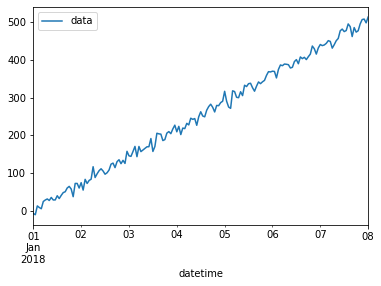

In [5]:
df.plot()
plt.show()

We can difference the time series using Pandas requires the [shift()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html?highlight=shift#pandas.DataFrame.shift) function by manually computing the difference of a Dataframe element with the previous element in the Dataframe.

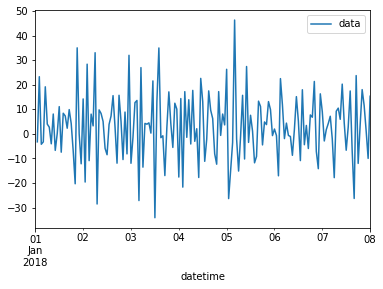

In [6]:
(df - df.shift(1)).plot()
plt.show()

Otherwise, we can also rely on Pandas by applying the [diff()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.diff.html) function that automatically calculates the difference of a Dataframe element compared with another element in the Dataframe (default is element in previous row).

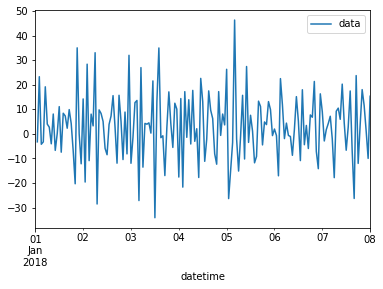

In [7]:
df.diff().plot()
plt.show()

### What about a quadratic trend?

The *single* diff allows us to detrend the time series that has a linear trend, like the one we analyzed above. But what if we have a quadratic trend (second-order), can we still use diff? The answer is yes, but we have to slightly adapt the approach.

Try to differentiate this synthetic data with a quadratic trend!

In [8]:
df2 = pd.DataFrame(date_rng, columns=['date'])
df2['data'] = 3*df2.index+1*df2.index**2+np.random.randn((len(date_rng)))*100
df2['datetime'] = pd.to_datetime(df2['date'])
df2 = df2.set_index('datetime')
df2.drop(['date'], axis=1, inplace=True)
df2.head()

,data
datetime,
2018-01-01 00:00:00,86.336462
2018-01-01 01:00:00,-15.901372
2018-01-01 02:00:00,7.266980
2018-01-01 03:00:00,17.745309
2018-01-01 04:00:00,35.097602


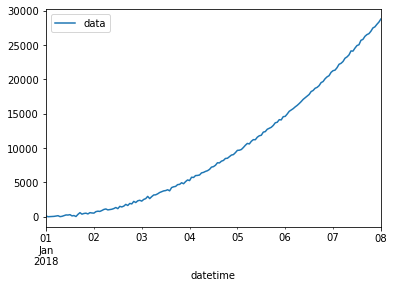

In [9]:
df2.plot()
plt.show()

If we try to apply the same approach as above we will not be able to remove the trend completely our data and we will not obtain a stationary time series:

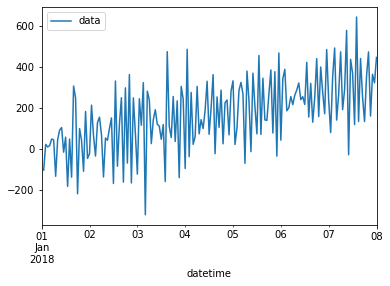

In [10]:
df2.diff().plot()
plt.show()

The solution is to **apply twice the diff function**, in order to remove completely the quadratic trend:

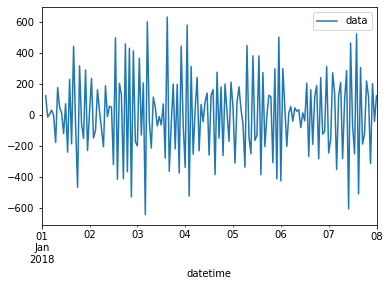

In [11]:
df2.diff().diff().plot()
plt.show()

Note that if we have multiple order trend, this process can be repeated, applying one diff after the other.

## Method 2: Detrend by model fitting

A trend is often easily visualized as a line through the observations. Linear trends can be summarized by a linear model, and nonlinear trends may be best summarized using a polynomial or other curve-fitting method. Because of the subjective and domain-specific nature of identifying trends, this approach can help to identify whether a trend is present. Even fitting a linear model to a trend that is clearly super-linear or exponential can be helpful. In addition to being used as a trend identification tool, these fit models can also be used to detrend a time series. For example, a linear model can be fit on the time index to predict the observation.

Let's start by considering the first dataset:

In [12]:
X = np.reshape([i for i in range(df.shape[0])], (-1, 1))
y = df['data'].values

We can fit a simple linear regression model

In [13]:
model = LinearRegression()
model.fit(X, y)
model.coef_, model.intercept_

(array([3.00192644]), 0.9359238948396751)

Once we obtain the model, we can compute the trend:

In [14]:
trend = model.predict(X)

And then we can proceed by substracing the trend the obtain from the original data:

In [15]:
detrended = [y[i]-trend[i] for i in range(df.shape[0])]

Let's look at what we obtained:

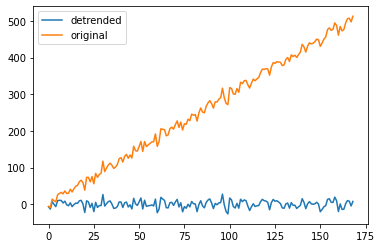

In [16]:
fig = plt.figure()
plt.plot(detrended, label='detrended')
plt.plot(y, label='original')
plt.legend()
plt.show()

What if we want to detrend by model fitting a time series with a quadratic or even higher order?

Let's consider again the synthetic data we previously created:

In [17]:
X = np.reshape([i for i in range(df2.shape[0])], (-1, 1))
y = df2['data'].values

If we try by fittting a linear regression model

In [18]:
model = LinearRegression()
model.fit(X, y)
model.coef_, model.intercept_
trend = model.predict(X)

In [19]:
# detrend data
detrended = [y[i]-trend[i] for i in range(df2.shape[0])]

We obtain the following data:

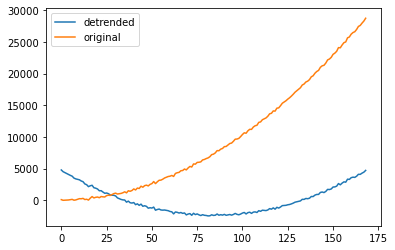

In [20]:
# plot detrended data
fig = plt.figure()
plt.plot(detrended, label='detrended')
plt.plot(y, label='original')
plt.legend()
plt.show()

The detrended time series is far from being stationary, indeed the quadratic trend is still present!

In case of non-linear trend, we have to apply the polynomial model, that allows us to perform a multi-order regression, like the one required for the quadratic trend.

In [21]:
X = np.reshape([i for i in range(df2.shape[0])], (-1, 1))
y = df2['data'].values

We can apply the [numpy.polyfit](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html) function to obtain a non-linear trend of our data:

In [22]:
model = np.poly1d(np.polyfit(X.flatten(), y, 2))
line = np.linspace(0, 168, len(X.flatten()))

Once obtained the trend, we can proceed as before to de-trend:

In [23]:
# detrend
detrended = [y[i]-model(line)[i] for i in range(df2.shape[0])]

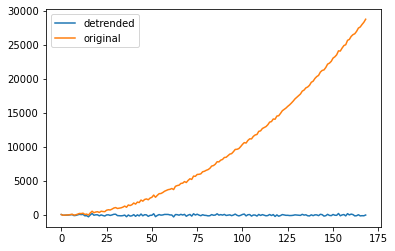

In [24]:
# plot detrended data
fig = plt.figure()
plt.plot(detrended, label='detrended')
plt.plot(y, label='original')
plt.legend()
plt.show()

## Combine Method 1 and Method 2 

Another solution to remove a quadratic trend consists in applying **the Linear Regression on the differenced data**.

In [25]:
X = np.reshape([i for i in range(df2.shape[0])], (-1, 1))
y = df2['data'].diff().values

In [26]:
# fit a linear regression model
model = LinearRegression()
model.fit(X[1:], y[1:])
model.coef_, model.intercept_

(array([2.02908562]), -0.7079708573503183)

In [27]:
# calculate trend
trend = model.predict(X)

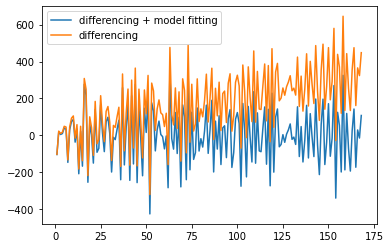

In [28]:
# detrend
detrended = [y[i]-trend[i] for i in range(df.shape[0])]
# plot detrended data
fig = plt.figure()
plt.plot(detrended, label='differencing + model fitting')
plt.plot(y, label='differencing')
plt.legend()
plt.show()